In [1]:
import pandas as pd
import os
from scipy import stats
import numpy as np
from os import listdir
import string

#Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Preparation: Calculate the forward returns for stocks and market indices

In [2]:
csv_path = "Data/"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 5 # this should depend on the rolling period

# calculate the forward returns
stock = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward = stock.shift(periods = -forward_day, freq = None, axis = 0)
# 5Dforward(t) = (close_price(t+5)-close_price(t))/close_price(t)
stockforwardreturn = (stockforward - stock) / stock
print(stockforwardreturn.head())
stockforwardreturn.to_csv(os.path.join(csv_path, '5DForward.csv')) #stock

index = pd.read_csv(csv_path + indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn = (indexforward - index) / index
print(indexforwardreturn.head())
indexforwardreturn.to_csv(os.path.join(csv_path, 'mkt_5DForward.csv')) #mkt

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04   0.047482   0.061368   0.088638   0.186231   0.065688   0.122858   
2007-01-05   0.188363   0.084177   0.094316   0.107551  -0.016348   0.037043   
2007-01-08   0.219149   0.158273   0.103618   0.111985   0.006898   0.031495   
2007-01-09   0.233333   0.230769   0.096691   0.135329   0.075422   0.031128   
2007-01-10   0.208806   0.006994   0.083142   0.096759  -0.043272   0.007674   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.250000   0.125307        0.0   0.128390  ...        NaN   
2007-01-05   0.122891   0.073622        0.0   0.079454  ...        NaN   
2007-01-08   0.140277   0.086213        0.0   0.092567  ...        NaN   
2007-01-09   0.130120   0.044423        0.0   0.123708  ...        Na

## Read the factors

In [3]:
factor_folder = "Data/ALL_factors/"
factor_list = set(os.listdir(factor_folder)) - set(['.DS_Store'])
factor_list = list(factor_list)

# Read all factor files
# Z-score the factor values to remove the scale differences
dfs = []
i = 0
for factor in factor_list:
    dfs.append(factor)
    df = pd.read_csv(factor_folder + factor , index_col = 0, parse_dates = True)
    dfs[i] = (df - df.mean()) / df.std() 
    i = i + 1

print(dfs[0].head())

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2008-01-02        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-07        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-08        NaN        NaN        NaN        NaN        NaN        NaN   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2008-01-02        NaN        NaN        NaN        NaN  ...        NaN   
2008-01-03        NaN        NaN        NaN        NaN  ...        NaN   
2008-01-04        NaN        NaN        NaN        NaN  ...        NaN   
2008-01-07        NaN        NaN        NaN        NaN  ...        Na

### Data Transformation

### Clean Return Data

In [4]:
# clean return data
import datetime
# rows cleaning
st = datetime.datetime(2008, 1, 2, 0, 0)
en = datetime.datetime(2018, 7, 5, 0, 0)
rt =stockforwardreturn[st:en]

a = dfs[0].columns.tolist()
b = rt.columns.tolist()
more = list(set(b) - set(a))
rt = rt.drop(more,axis=1)

In [5]:
print(rt.shape)
print(dfs[0].shape)

(2557, 3569)
(2557, 3569)


### Melt DataFrames as One

In [6]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].reset_index()
    dfs[i] = pd.melt(frame=dfs[i],id_vars='date',value_vars=dfs[i].columns.tolist()[1:],var_name='stock',value_name=factor_list[i].rstrip('.csv'))

In [7]:
melted = pd.DataFrame()
melted = pd.concat([melted,dfs[0]],axis=1)

In [8]:
for i in range(1,len(dfs)):
    melted = pd.merge(left=melted,right=dfs[i],on=['date','stock'])

In [9]:
rt = rt.reset_index()
rt = pd.melt(frame=rt ,id_vars='date', value_vars=rt.columns.tolist()[1:],var_name='stock',value_name='return')

In [10]:
melted = pd.merge(left=melted,right=rt,on=['date','stock'])

In [11]:
melted.head()

,date,stock,RealizedVolatility,AD,VEMA10,EMA26,TVMA6,DAVOL20,return
0,2008-01-02,000001.SZ,NaN,-0.992037,-0.717872,0.986489,-0.001905,-0.158321,0.082412
1,2008-01-03,000001.SZ,NaN,-0.991141,-0.703739,0.980896,0.022230,-0.206822,0.123159
2,2008-01-04,000001.SZ,NaN,-0.986487,-0.716201,0.984013,0.032540,-0.255323,0.148814
3,2008-01-07,000001.SZ,NaN,-0.981773,-0.690041,0.993490,0.149184,-0.134070,0.109267
4,2008-01-08,000001.SZ,NaN,-0.981442,-0.610939,1.012231,0.268527,0.059935,0.040604


In [12]:
melted.shape

(9125933, 9)

In [13]:
na = melted.dropna()

In [14]:
na.shape
from sklearn import preprocessing
na['return'] = preprocessing.scale(na['return'])

#na.to_csv(os.path.join(csv_path, 'na.csv'))
#na = pd.read_csv( "Data/na.csv", index_col = 0, parse_dates = True)

### Train-Test Split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X=na.drop(['return','date','stock'],axis=1)
y=na.filter(['return'])

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=233)

In [18]:
X_train.head()

,RealizedVolatility,AD,VEMA10,EMA26,TVMA6,DAVOL20
6283586,-0.071019,-0.489395,-0.736380,-0.825846,-0.634460,-0.755335
7352904,-0.517177,-0.207811,-0.604206,-0.947358,-0.454428,-0.165355
5323557,-0.132727,-0.425239,-0.457278,0.028461,-0.475525,-0.727243
5471085,0.161054,0.037255,0.961062,-0.446625,0.113911,1.052010
2068517,-0.485113,-1.051109,-0.341651,-0.001431,-0.470100,-0.126192


In [19]:
y_train.head()

,return
6283586,-0.295989
7352904,-0.849503
5323557,0.346721
5471085,2.367912
2068517,0.107217


### Support Vector Regression

In [20]:
X_train=np.array(X_train)
print(X_train)
X_test=np.array(X_test)
print(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train=y_train.ravel()
y_test=y_test.ravel()
print(y_train)
print(y_test)

[[-0.07101908 -0.48939529 -0.73638003 -0.82584602 -0.63446014 -0.75533509]
 [-0.5171773  -0.20781086 -0.60420602 -0.9473582  -0.45442829 -0.16535462]
 [-0.13272704 -0.42523906 -0.45727837  0.02846134 -0.47552451 -0.72724315]
 ...
 [-0.45983632  1.32694512 -0.71483291 -0.75126084 -0.48224296 -0.01117334]
 [-0.6304899   0.33524045  1.5451075   0.35365916  2.29449517  2.30716858]
 [-0.35386485 -0.6683114  -0.61599191 -0.65367604 -0.52944255 -0.26108872]]
[[ 0.04415229 -0.78111818 -0.5682125   0.98759955 -0.17969294 -0.85811424]
 [ 0.3015243  -0.13766089 -0.45419247 -0.36359196 -0.44216155  0.44952073]
 [-0.67577263 -0.16736487  0.74753362  0.1737415   0.29539641  1.33642492]
 ...
 [-0.86239438  1.12309794  0.57886409  1.57900858  0.16978122  0.12424207]
 [-0.49088385 -0.73373855 -0.32116605 -0.87716339 -0.62264889 -0.13583648]
 [-0.00408005  0.0613756   2.09057225 -0.53937633  1.08635202  2.19364725]]
[-0.29598942 -0.84950265  0.34672061 ... -0.05348505 -0.89138539
 -0.03679899]
[-1.24182

In [21]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

def test_SVR(result_svr, y_test, y_predict): #linear_svr, poly_svr, rbf_svr
    print('R-squared value of SVR is',result_svr.score(X_test,y_test))
    print('The mean squared error of SVR is',mean_squared_error(y_test,y_predict))
    print('The mean absolute error of SVR is',mean_absolute_error(y_test,y_predict))

In [22]:
from sklearn.svm import SVR

linear_svr=SVR(kernel='linear', max_iter = 1000)
linear_svr.fit(X_train,y_train)
linear_svr_y_predict=linear_svr.predict(X_test)
print(linear_svr_y_predict)

test_SVR(linear_svr, y_test, linear_svr_y_predict)

[-5.80695843 -5.14581411 -5.92030238 ... -7.89927284 -5.1339106
 -5.4852269 ]
R-squared value of SVR is -34.39923315822454
The mean squared error of SVR is 35.380171020976206
The mean absolute error of SVR is 5.76762100174762


In [23]:
poly_svr=SVR(kernel='poly', max_iter = 1000)  
poly_svr.fit(X_train,y_train)
poly_svr_y_predict=poly_svr.predict(X_test)
print(poly_svr_y_predict)

test_SVR(poly_svr, y_test, poly_svr_y_predict)

[55.10164869 55.19013654 55.20402819 ... 54.83703294 55.18108531
 55.18717707]
R-squared value of SVR is -3044.363806915258
The mean squared error of SVR is 3043.723908598844
The mean absolute error of SVR is 55.131888285373954


In [24]:
rbf_svr=SVR(kernel='rbf', max_iter = 1000)  
rbf_svr.fit(X_train,y_train)
rbf_svr_y_predict=rbf_svr.predict(X_test)
print(rbf_svr_y_predict)

test_SVR(rbf_svr, y_test, rbf_svr_y_predict)

[-0.96608273 -1.39594772 -1.38890869 ... -0.47854924 -1.17846822
  0.43672288]
R-squared value of SVR is -0.9436743854021651
The mean squared error of SVR is 1.9426277359525854
The mean absolute error of SVR is 1.0571281834323034


After comparison, the kernel type of 'rbf' gives us the best result.

## SVR Cross Validation

In [26]:
def SVR_mse(X_train, y_train, X_test, y_test):
    rbf_svr=SVR(kernel='rbf', max_iter = 200)
    rbf_svr.fit(X_train,y_train)
    y_predict=rbf_svr.predict(X_test)
    return mean_squared_error(y_test,y_predict)

In [27]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=10)
kfold_baseset=na.filter(['AD','DAVOL20','EMA26','RealizedVolatility','TVMA6','VEMA10','return'])
kfold_baseset=np.array(kfold_baseset)
X=np.array(X)
y=np.array(y)
MSE=0
for train_idex, test_index in kf.split(kfold_baseset):
    X_train,y_train=X[train_idex],y[train_idex]
    X_test,y_test=X[test_index],y[test_index]
    y_train=y_train.ravel()
    y_test=y_test.ravel()
    MSE= MSE + SVR_mse(X_train,y_train,X_test,y_test)
print('The mean squared error of SVR after cross validation is', MSE / 10)

The mean squared error of SVR after cross validation is 2.467784022524122


## SVR predict results

In [28]:
SVR_predict_y=rbf_svr.predict(X)

In [29]:
SVR_predict_y=pd.DataFrame(SVR_predict_y)
print(SVR_predict_y)
save_result_path = 'Data/'
SVR_predict_y.to_csv(os.path.join(save_result_path, 'SVR_result.csv'))
na.insert(loc=0,column='predictedy',value=SVR_predict_y.values)
for_bt=pd.merge(melted,na,how='left',on=['date','stock'])
for_bt=for_bt[['date','stock','predictedy']]
#formatting
td_bt=pd.Series(list(for_bt['predictedy']),index=[for_bt['date'],for_bt['stock']])
td_bt=td_bt.unstack()
save_result_path ='Data/'
print(td_bt.shape)
td_bt.to_csv(os.path.join(save_result_path, 'SVR.csv'))

                0
0        0.533958
1        0.348088
2        0.189241
3        0.150924
4        0.025128
...           ...
5345982 -0.832762
5345983 -0.649730
5345984 -0.574635
5345985 -0.496860
5345986 -0.528648

[5345987 rows x 1 columns]
(2557, 3569)


## Backtesting Simulation

After you save the score from your new factor in the same format as "Simple_Mean_factor.csv". You can directly run the following codes to see the backtesting simulation results. 

"helper.py" contains all formulas and plotting functions.

"backtestlite.py" contains the whole simulation process. 


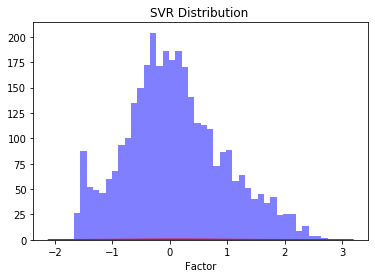

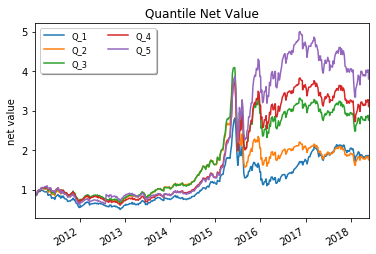

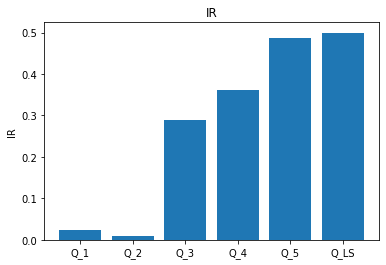

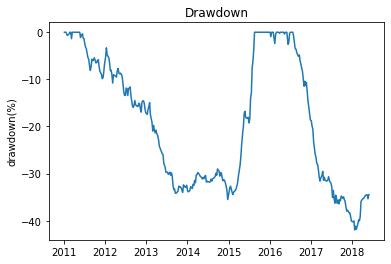

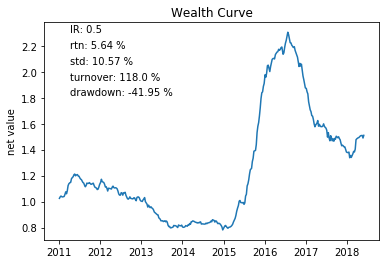

In [30]:
import backtestlite as bt
import helper

working_directory = 'Data/'
#Directory to import the factor you built
factor_path_all = 'Data/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
direction = "Descending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor = "SVR"
Type = "LS" # this stand for long-short strategy. 


def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = bt.Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = helper.DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)